# Derive ffCO2 from the APO observations

In [1]:
import os, glob
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs

import plot_info, han_func

In [2]:
year = 2014
months = [8, 12] 
sites = ['WAO']
ocean_sims = ['ECCO', 'Jena', 'NEMO']

months = [months] if type(months)==int else months

start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

nrows = len(months) * len(sites)

sites = {site: code for site, code in plot_info.sitecodes.items() if site in sites}

date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[1]).zfill(2)}' if len(months)==2 else None
print(date_str)

201408-201412


## Calculate APO timeseries

### Get the component timeseries data

Import the pre-run forward models

In [3]:
ts_data_all = han_func.get_timeseries(sites=sites.keys(), year=year, sources=['ff', 'ocean', 'bc'])
ts_data_all = {site: {month: ts_site.sel(time=slice(start, end_dates[month]))
                      for month, start in start_dates.items()}
               for site, ts_site in ts_data_all.items()}

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2014.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2014.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2014.nc']

Data variables:
['co2_ff', 'o2_ff', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']


## Get the obs

- Get the observations for the monhs specified
- For each month we also import the observations from the month before so that we can test using a rolling average to subtract a baseline

In [4]:
apo_obs = {month: get_obs(list(sites.keys()), 'APO', start_date - relativedelta(months=1), end_dates[month], keep_missing=True)
           for month, start_date in start_dates.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-07-01 00:00:00 to 2014-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-11-01 00:00:00 to 2014-12-31 23:59:58.999999999


## Plot the APO

Plot the APO observations and the Jena CarboScope baseline


In [13]:
site = 'WAO'
for month, apo_month in apo_obs.items():
  fig = go.Figure()

  fig.add_trace(go.Scatter(
    x = apo_month[site][0].sel(time=slice(start_dates[month], end_dates[month])).time,
    y = apo_month[site][0].sel(time=slice(start_dates[month], end_dates[month])).mf,
    name = 'observations',
    line = dict(color=plot_info.colors['obs'])
  ))

  fig.add_trace(go.Scatter(
    x = ts_data_all[site][month].time,
    y = ts_data_all[site][month].apo_bc,
    name = 'Jena Carboscope baseline',
    line = dict(color='grey')
  ))

  fig.update_layout(yaxis_title = r'APO, per meg', margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

  fig.show()

## Calculate baseline adjustment

- Select several points that look reasonably unaffected by local influence (small O2 uptake)
- Find the difference between those points and the baseline, and take the average

In [12]:
site = list(sites.keys())[0]

base_datetimes = {8: ['2014-08-01T23:00', '2014-08-04T01:00', '2014-08-13T11:00', '2014-08-31T00:00', '2014-08-31T21:00'],
                  12: ['2014-12-01T11:00', '2014-12-04T11:00', '2014-12-06T07:00', '2014-12-07T12:00', '2014-12-15T07:00']}
obs_base_points = {month: apo_obs[month][site][0].mf.sel(time=base_month)
                   for month, base_month in base_datetimes.items()}
jena_base_points = {month: ts_data_all[site][month].apo_bc.sel(time=base_month)
                    for month, base_month in base_datetimes.items()}

### Check out the adjustment

Find the average of the differences, use this to adjust the baseline, and have a look at how well this seems to match the obs

In [13]:
base_diff = {month: obs_base_month - jena_base_points[month]
             for month, obs_base_month in obs_base_points.items()}
base_diff_ave = {month: diff_month.values.mean() for month, diff_month in base_diff.items()}

for month, diff_month in base_diff_ave.items():
  print(f'{month}, baseline difference: {diff_month} per meg')

for month, apo_month in apo_obs.items():
  fig = go.Figure()

  fig.add_trace(go.Scatter(
    x = apo_month[site][0].sel(time=slice(start_dates[month], end_dates[month])).time,
    y = apo_month[site][0].sel(time=slice(start_dates[month], end_dates[month])).mf,
    name = 'observations',
    line = dict(color=plot_info.colors['obs'])
  ))

  fig.add_trace(go.Scatter(
    x = ts_data_all[site][month].time,
    y = ts_data_all[site][month].apo_bc + base_diff_ave[month],
    name = 'Jena Carboscope baseline',
    line = dict(color='grey')
  ))

  fig.update_layout(yaxis_title = r'APO, per meg', margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

  fig.show()

8, baseline difference: 7.673499465683506 per meg
12, baseline difference: -7.353160395588804 per meg


## Subtract the baseline

In [14]:
apo_obs_bkgsub = {month: apo_month[site][0].mf.sel(time=slice(start_dates[month], end_dates[month])) - 
                         (ts_data_all[site][month].apo_bc + base_diff_ave[month])
                  for month, apo_month in apo_obs.items()}

for month, apo_month in apo_obs_bkgsub.items():
  fig = go.Figure()

  fig.add_trace(go.Scatter(
    x = apo_month.time,
    y = apo_month,
    name = 'observations - bkg',
    line = dict(color=plot_info.colors['obs'])
  ))

  fig.update_layout(yaxis_title = r'APO, per meg', margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

  fig.show()

### Get the weighted oxidative ratios

In [15]:
ox_ratio_file = glob.glob(os.path.join('/user','work','vf20487', 'Timeseries', 'OxidativeRatio', f'WeightedAPORatio-gridfed-ukghg_timeseries_{year}.nc'))
ox_ratio_data = name.open_ds(ox_ratio_file[0])

In [16]:
ffco2 = {'varying_ratio': {month: ox_ratio_data.apo_ratio.sel(time=slice(start_dates[month], end_dates[month])) * obs_month
                           for month, obs_month in apo_obs_bkgsub.items()},
         'constant_ratio': {month: -0.3 * obs_month
                            for month, obs_month in apo_obs_bkgsub.items()}}


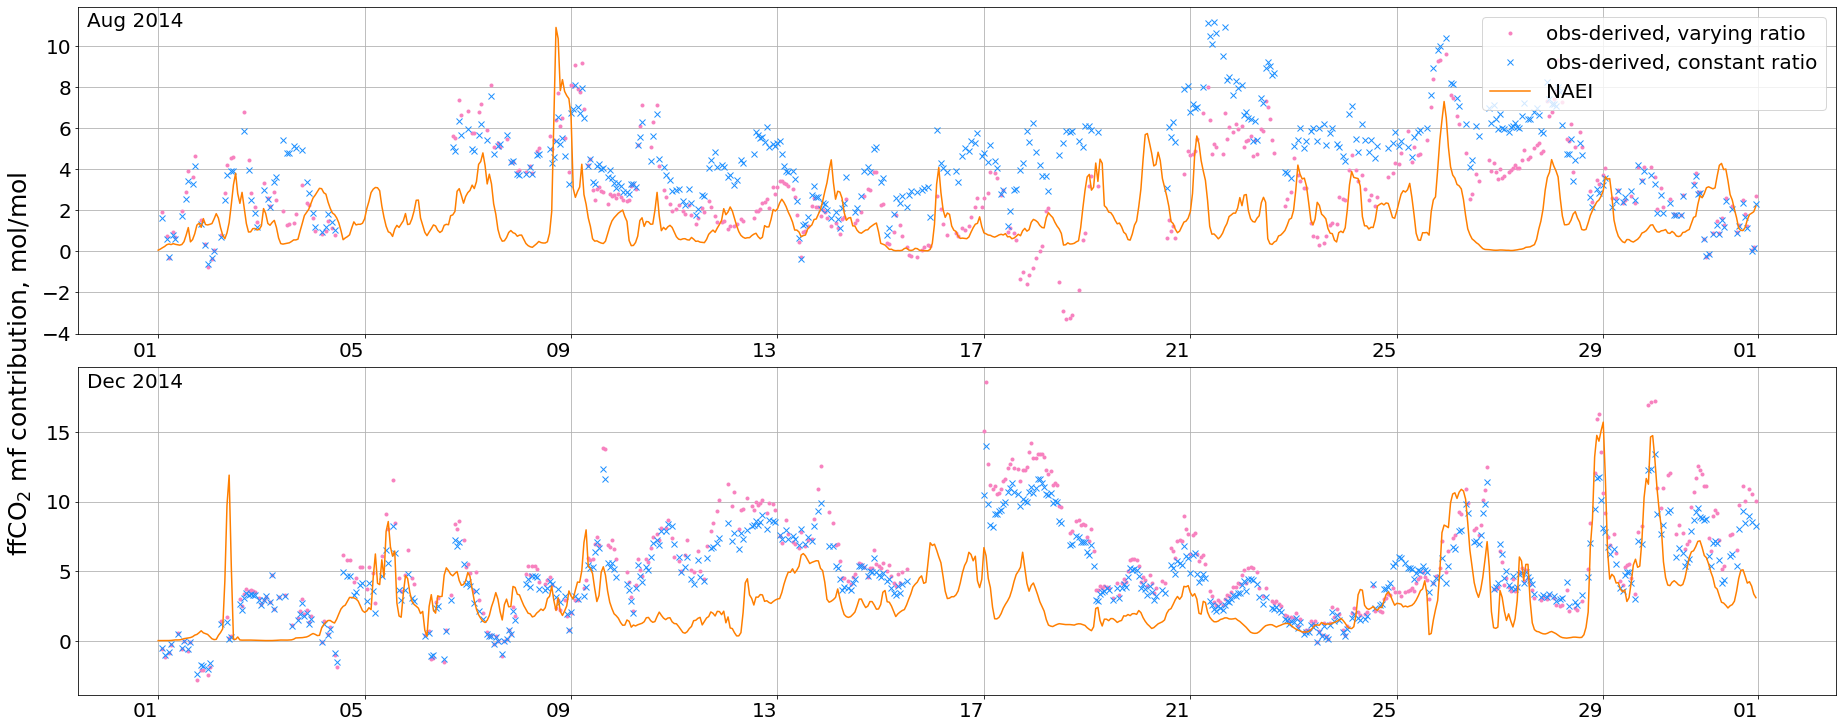

In [17]:
info = {'varying_ratio': {'color': plot_info.colors['obs'], 'marker': '.'},
        'constant_ratio': {'color': 'dodgerblue', 'marker': 'x'}}

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, 5*nrows), constrained_layout=True)

obs_plots = {ratio: {month: ffco2_month.plot(ax=axes[mm], color=info[ratio]['color'], marker=info[ratio]['marker'], ls='none',
                                             label=f'obs-derived, {" ".join(ratio.split("_"))}')
                     for mm, (month, ffco2_month) in enumerate(ffco2_ratio.items())}
             for ratio, ffco2_ratio in ffco2.items()} 
naei_plot = {month: ts_month.co2_ff.plot(ax=axes[mm], color=plot_info.colors['ff'], label='NAEI')
             for mm, (month, ts_month) in enumerate(ts_data_all[site].items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[mm*len(sites)].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

legend = axes[0].legend(loc='upper right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
ylabels = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, r'ffCO$_2$ mf contribution, mol/mol', va='center', ha='center', rotation='vertical', fontsize=25)

filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2', 
                            f'ffCO2_APOobs_{site}_{date_str}.png')
# print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Calculate the correlation

In [20]:
0.4**2, 0.5**2

(0.16000000000000003, 0.25)

In [19]:
rmse = {ratio: {month: (((ts_data_all[site][month].co2_ff - ffco2_month)**2).mean().values)**0.5
                for month, ffco2_month in ffco2_ratio.items()}
        for ratio, ffco2_ratio in ffco2.items()}

correlations = {ratio: {month: xr.corr(ffco2_month, ts_data_all[site][month].co2_ff).values**2
                        for month, ffco2_month in ffco2_ratio.items()}
                for ratio, ffco2_ratio in ffco2.items()}

print('RMSE')
print_rmse = [[print(f'{ratio}, {plot_info.month_names[month]} rmse:    {rmse_month}')
               for month, rmse_month in rmse_ratio.items()]
              for ratio, rmse_ratio in rmse.items()] 
print('\nCorrelation')
print_corr = [[print(f'{ratio}, {plot_info.month_names[month]} correlation:    {corr_month}')
               for month, corr_month in corr_ratio.items()]
              for ratio, corr_ratio in correlations.items()]

RMSE
varying_ratio, Aug rmse:    2.611227909242867
varying_ratio, Dec rmse:    4.183999436206522
constant_ratio, Aug rmse:    3.674047155355758
constant_ratio, Dec rmse:    3.4220964933654625

Correlation
varying_ratio, Aug correlation:    0.1680246776923928
varying_ratio, Dec correlation:    0.27838570937722024
constant_ratio, Aug correlation:    0.03379564961192083
constant_ratio, Dec correlation:    0.2426038099638802


In [47]:
rmse_ratios = {month: (((ffco2['constant_ratio'][month] - ffco2_month)**2).mean().values)**0.5
        for month, ffco2_month in ffco2['varying_ratio'].items()}

correlations_ratios = {month: xr.corr(ffco2_month, ffco2['constant_ratio'][month]).values
                       for month, ffco2_month in ffco2['varying_ratio'].items()}

print('RMSE')
print_rmse = [print(f'{plot_info.month_names[month]} rmse:    {rmse_month}')
               for month, rmse_month in rmse_ratios.items()]
print('\nCorrelation')
print_corr = [print(f'{plot_info.month_names[month]} correlation:    {corr_month}')
              for month, corr_month in correlations_ratios.items()]

RMSE
Aug rmse:    2.2241937031179093
Dec rmse:    1.2265877380769155

Correlation
Aug correlation:    0.6669127649847495
Dec correlation:    0.9794323335863301


## A different background subtraction

Try taking a rolling average to subtract

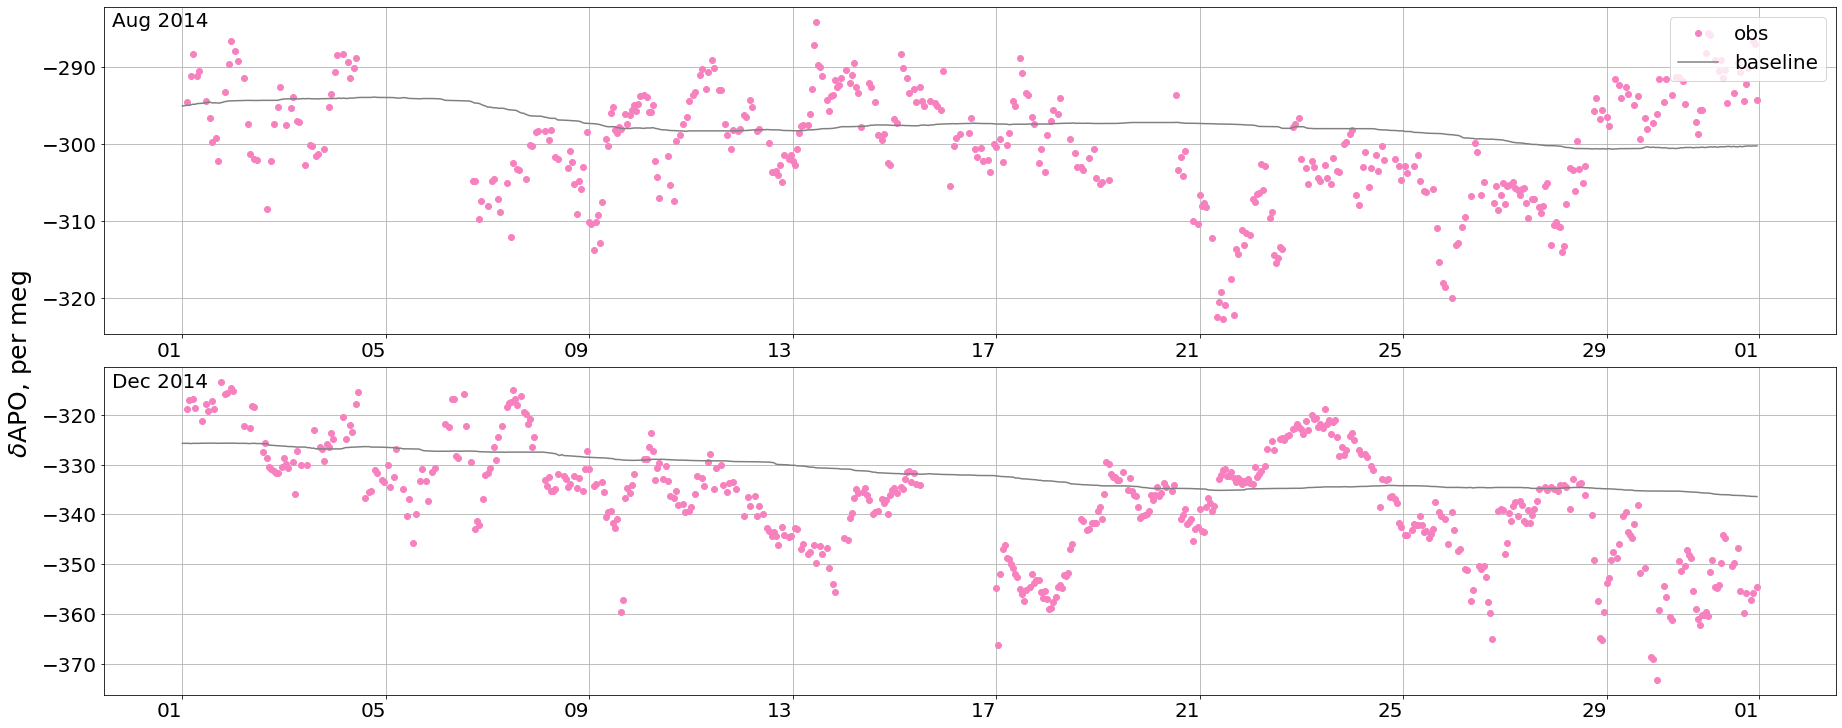

In [28]:
rolling_base = {month: apo_month[site][0].mf.rolling(time=30*24, min_periods=24*10).median().sel(time=slice(start_dates[month], end_dates[month]))
                for month, apo_month in apo_obs.items()}

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, 5*nrows), constrained_layout=True)

obs_plots = {month: apo_month[site][0].mf.sel(time=slice(start_dates[month], end_dates[month])).plot(ax=axes[mm], color=plot_info.colors['obs'], marker='o', ls='none',
                                             label='obs')
             for mm, (month, apo_month) in enumerate(apo_obs.items())}
base_plot = {month: base_month.plot(ax=axes[mm], color='grey', label='baseline')
             for mm, (month, base_month) in enumerate(rolling_base.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[mm*len(sites)].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

legend = axes[0].legend(loc='upper right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
ylabels = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)